In [5]:
import pandas as pd 
df=pd.read_csv('classification.csv')

c:\Users\pc\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 — Train Loss 0.4234 | Train Acc 0.8191 — Val Loss 0.3321 | Val Acc 0.8556
Epoch 2/100 — Train Loss 0.3215 | Train Acc 0.8603 — Val Loss 0.3165 | Val Acc 0.8559
Epoch 3/100 — Train Loss 0.3018 | Train Acc 0.8667 — Val Loss 0.2994 | Val Acc 0.8693
Epoch 4/100 — Train Loss 0.2889 | Train Acc 0.8746 — Val Loss 0.2892 | Val Acc 0.8718
Epoch 5/100 — Train Loss 0.2829 | Train Acc 0.8762 — Val Loss 0.2878 | Val Acc 0.8712
Epoch 6/100 — Train Loss 0.2739 | Train Acc 0.8817 — Val Loss 0.2820 | Val Acc 0.8759
Epoch 7/100 — Train Loss 0.2657 | Train Acc 0.8836 — Val Loss 0.2775 | Val Acc 0.8799
Epoch 8/100 — Train Loss 0.2608 | Train Acc 0.8868 — Val Loss 0.2793 | Val Acc 0.8775
Epoch 9/100 — Train Loss 0.2496 | Train Acc 0.8908 — Val Loss 0.2743 | Val Acc 0.8774
Epoch 10/100 — Train Loss 0.2434 | Train Acc 0.8936 — Val Loss 0.3172 | Val Acc 0.8761
Epoch 11/100 — Train Loss 0.2350 | Train Acc 0.8982 — Val Loss 0.3070 | Val Acc 0.8742
Epoch 12/100 — Train Loss 0.2236 | Train Acc 0.9027 

C:\Users\pc\AppData\Local\Temp\ipykernel_9984\3237597479.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_classifier.pth"))


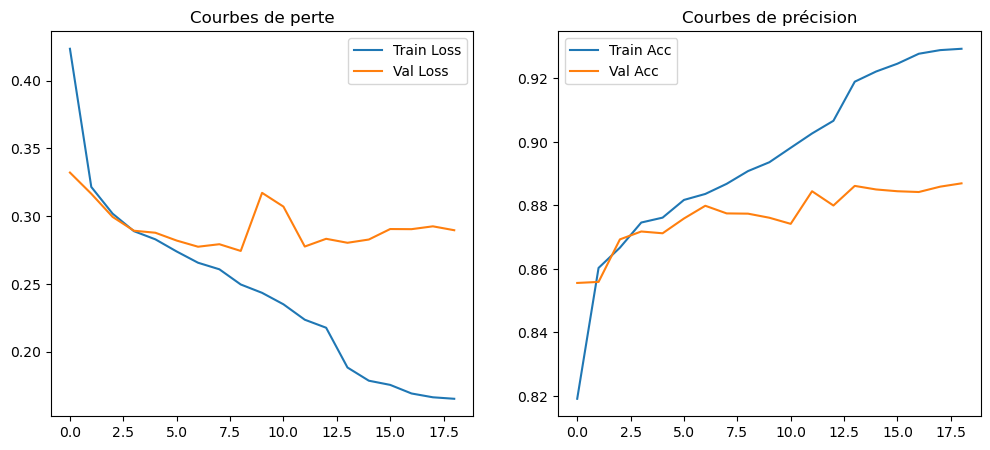

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate

# --- 1) Chargement et nettoyage du DataFrame ---
try:
    df
except NameError:
    df = pd.DataFrame(columns=[
        "filename_lr", "age", "sex", "height", "weight",
        "Myocardial Infarction (MI)", "ST/T Change (STTC)",
        "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"
    ])

image_dir = 'records100'
df["filename_lr"] = df["filename_lr"].apply(lambda p: os.path.join(image_dir, p.split("/")[-1] + ".png"))
df = df[df["filename_lr"].apply(os.path.exists)].reset_index(drop=True)

target_columns = [
    "Myocardial Infarction (MI)", "ST/T Change (STTC)",
    "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"
]

# --- 2) Transformation légère (sans augmentation) ---
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- 3) Dataset ---
class ECGDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["filename_lr"].tolist()
        self.tab = torch.tensor(df[["age", "sex", "height", "weight"]].values, dtype=torch.float32)
        self.labels = torch.tensor(df[target_columns].values, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = Image.open(path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            return None
        if self.transform:
            img = self.transform(img)
        return img, self.tab[idx], self.labels[idx]

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if batch else []

# --- 4) Préparation des DataLoaders ---
df_train = df.sample(frac=0.8, random_state=42)
df_val = df.drop(df_train.index)

train_ds = ECGDataset(df_train, transform=image_transform)
val_ds = ECGDataset(df_val, transform=image_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# --- 5) Modèle CNN Léger ---
class LightCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        def dw_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),
                nn.BatchNorm2d(in_c),
                nn.ReLU(),
                nn.Conv2d(in_c, out_c, kernel_size=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
        self.conv1 = dw_conv(3, 16)
        self.conv2 = dw_conv(16, 32)
        self.conv3 = dw_conv(32, 64)

        self.cnn_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.mlp = nn.Sequential(
            nn.Linear(4, 16), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32), nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 + 32, 64), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, len(target_columns))
        )

    def forward(self, img, tab):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.cnn_fc(x)
        y = self.mlp(tab)
        return self.classifier(torch.cat([x, y], dim=1))

# --- 6) Entraînement ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

best_loss = float('inf')
patience, wait = 10, 0
num_epochs = 100

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    # --- Phase d'entraînement ---
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, tabs, labs in train_loader:
        if len(imgs) == 0: continue
        imgs, tabs, labs = imgs.to(device), tabs.to(device), labs.to(device)
        optimizer.zero_grad()
        out = model(imgs, tabs)
        loss = criterion(out, labs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = (torch.sigmoid(out) > 0.5).float()
        correct += (preds == labs).sum().item()
        total += labs.numel()

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # --- Phase de validation ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, tabs, labs in val_loader:
            if len(imgs) == 0: continue
            imgs, tabs, labs = imgs.to(device), tabs.to(device), labs.to(device)
            out = model(imgs, tabs)
            val_loss += criterion(out, labs).item()
            preds = (torch.sigmoid(out) > 0.5).float()
            correct += (preds == labs).sum().item()
            total += labs.numel()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    scheduler.step(val_losses[-1])

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss {train_losses[-1]:.4f} | Train Acc {train_accs[-1]:.4f} — "
          f"Val Loss {val_losses[-1]:.4f} | Val Acc {val_accs[-1]:.4f}")

    # Early stopping
    if val_losses[-1] < best_loss:
        best_loss = val_losses[-1]
        torch.save(model.state_dict(), "ecg_classifier.pth")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping")
            break

# --- 7) Chargement du meilleur modèle ---
model.load_state_dict(torch.load("ecg_classifier.pth"))

# --- 8) Visualisation ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Courbes de perte")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Courbes de précision")
plt.legend()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

df_temp, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_temp, test_size=0.2, random_state=42)

train_ds = ECGDataset(df_train, transform=image_transform)
val_ds = ECGDataset(df_val, transform=image_transform)
test_ds = ECGDataset(df_test, transform=image_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [9]:
model.eval()
test_loss, correct, total = 0, 0, 0

with torch.no_grad():
    for imgs, tabs, labs in test_loader:
        if len(imgs) == 0: continue
        imgs, tabs, labs = imgs.to(device), tabs.to(device), labs.to(device)
        out = model(imgs, tabs)
        loss = criterion(out, labs)
        test_loss += loss.item()
        preds = (torch.sigmoid(out) > 0.5).float()
        correct += (preds == labs).sum().item()
        total += labs.numel()

test_loss /= len(test_loader)
test_acc = correct / total

print(f"🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


🧪 Test Loss: 0.2068 | Test Accuracy: 0.9148


In [10]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, tabs, labs in test_loader:
        if len(imgs) == 0: continue
        imgs, tabs = imgs.to(device), tabs.to(device)
        out = model(imgs, tabs)
        preds = (torch.sigmoid(out) > 0.5).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labs.numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print(classification_report(all_labels, all_preds, target_names=target_columns))


                             precision    recall  f1-score   support

 Myocardial Infarction (MI)       0.82      0.40      0.53       214
         ST/T Change (STTC)       0.70      0.58      0.63       247
Conduction Disturbance (CD)       0.78      0.83      0.81        83
          Hypertrophy (HYP)       0.75      0.78      0.77       149
              Normal (NORM)       0.90      0.90      0.90       565

                  micro avg       0.83      0.73      0.78      1258
                  macro avg       0.79      0.70      0.73      1258
               weighted avg       0.82      0.73      0.76      1258
                samples avg       0.66      0.64      0.64      1258



c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


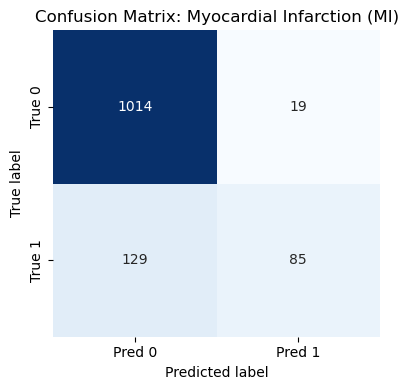

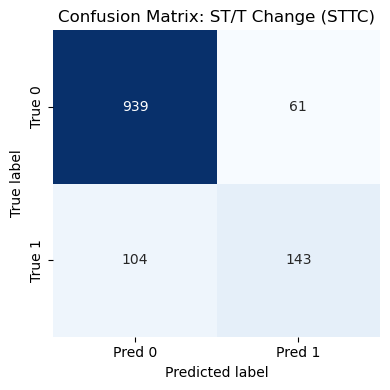

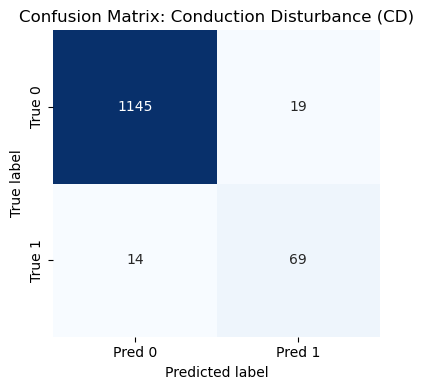

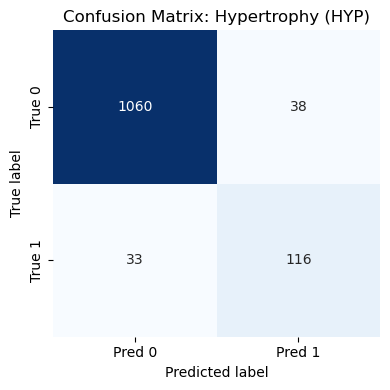

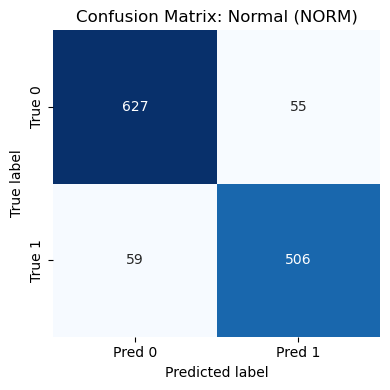

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Matrices de confusion multilabel ---
mcm = multilabel_confusion_matrix(all_labels, all_preds)

# --- 3. Affichage ---
for i, label in enumerate(target_columns):
    tn, fp, fn, tp = mcm[i].ravel()
    matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(4, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix: {label}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [14]:
import torch
import torch.nn as nn

class LightCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        def dw_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),
                nn.BatchNorm2d(in_c),
                nn.ReLU(),
                nn.Conv2d(in_c, out_c, kernel_size=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
        self.conv1 = dw_conv(3, 16)
        self.conv2 = dw_conv(16, 32)
        self.conv3 = dw_conv(32, 64)

        self.cnn_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.mlp = nn.Sequential(
            nn.Linear(4, 16), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32), nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 + 32, 64), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 5)  # 5 classes ici !
        )

    def forward(self, img, tab):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.cnn_fc(x)
        y = self.mlp(tab)
        return self.classifier(torch.cat([x, y], dim=1))


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCNN().to(device)
model.load_state_dict(torch.load("ecg_classifier.pth", map_location=device))
model.eval()



C:\Users\pc\AppData\Local\Temp\ipykernel_9984\173746092.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_classifier.pth", map_locati

LightCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 

In [22]:
from PIL import Image
from torchvision import transforms
import torch

# Même transform que pour l'entraînement
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Exemple : prédiction pour une image
img_path = r"records100\00068_lr.png"  # change selon ton cas
image = Image.open(img_path).convert("RGB")
image = image_transform(image).unsqueeze(0).to(device)  # (1, 3, 128, 128)

# Données tabulaires associées (âge, sexe, taille, poids)
tab_data = torch.tensor([[48.0, 1.0, 0.0, 92.00]], dtype=torch.float32).to(device)  # 1 ligne

# --- Prédiction ---
with torch.no_grad():
    output = model(image, tab_data)
    probs = torch.sigmoid(output).cpu().numpy()[0]


In [23]:
# Affichage des résultats
for label, prob in zip(target_columns, probs):
    print(f"{label}: {prob:.2f}")

Myocardial Infarction (MI): 0.18
ST/T Change (STTC): 0.06
Conduction Disturbance (CD): 0.01
Hypertrophy (HYP): 0.01
Normal (NORM): 0.72
